# MNIST

In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 

%matplotlib inline

In [5]:
digits = load_digits()

<Figure size 432x288 with 0 Axes>

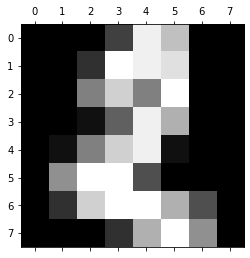

In [8]:
plt.gray()
plt.matshow(digits.images[2])

In [10]:
X, y = digits['data'], digits['target']
print(X.shape, y.shape)

(1797, 64) (1797,)


In [11]:
X_train, y_train, X_test, y_test = X[:1450], y[:1450], X[1450:], y[1450:]

# 随机打乱训练集

In [12]:
shuffle_index = np.random.permutation(1450)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 二分类

简化一下问题，只尝试去识别一个数字，判断是输入数字是1还是不是1

In [17]:
y_train_1 = (y_train == 1)
y_test_1 = (y_test == 1)

In [16]:
y_train

array([3, 2, 7, ..., 8, 2, 1])

# SGDClassifier

这个分类器有一个好处是能够高效地处理非常大的数据集。这部分原因在于SGD一次只处理一条数据，这也使得 SGD 适合在线学习（online learning）。

In [18]:
from sklearn.linear_model import SGDClassifier

In [19]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_1)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
sgd_clf.predict([X_train[1449]])

array([ True])

## 评估这个模型的性能

### cross_val_score

使用 `cross_val_score()` 函数来评估 `SGDClassifier` 模型，同时使用 K 折交叉验证，此处让 `k=3`。

> 记住：K 折交叉验证意味着把训练集分成 K 折（此处 3 折），然后使用一个模型对其中一折进行预测，对其他折进行训练。

In [28]:
from sklearn.model_selection import cross_val_score

In [29]:
cross_val_score(sgd_clf, X_train, y_train_1, cv=3, scoring="accuracy")

array([0.96280992, 0.97107438, 0.98340249])

交叉验证上有大于 95% 的精度（accuracy）？这看起来很令人吃惊。

> 因为正例和负例数量不均衡

### 混淆矩阵

就是，吴恩达老师讲准确率和召回率处的内容。

__混淆矩阵中的每一行表示一个实际的类, 而每一列表示一个预测的类__。

> 对于二分类问题，混淆矩阵返回的是一个 `2 x 2` 的矩阵，意义也和吴恩达老师讲的相同

为了计算混淆矩阵，首先你需要有一系列的预测值，这样才能将预测值与真实值做比较。

> `cross_val_predict`: 它不是返回一个评估分数，而是 __返回基于每一个测试折做出的一个预测值__。这意味着，对于每一个训练集的样例，你得到一个干净的预测（“干净”是说一个模型在训练过程当中没有用到测试集的数据）。

In [33]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3)

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_1, y_train_pred)

array([[1284,   20],
       [  15,  131]])

In [35]:
y_train_pred

array([False, False, False, ..., False, False,  True])

### 准确率/召回率/F1

* 准确率：
* 召回率：
* F1：

F1 支持那些有着相近准确率和召回率的分类器。这不会总是你想要的。有的场景你会绝大程度地关心准确率，而另外一些场景你会更关心召回率。举例子，如果你训练一个分类器去检测视频是否适合儿童观看，你会倾向选择那种即便拒绝了很多好视频、但保证所保留的视频都是好（高准确率）的分类器，而不是那种高召回率、但让坏视频混入的分类器（这种情况下你或许想增加人工去检测分类器选择出来的视频）。另一方面，加入你训练一个分类器去检测监控图像当中的窃贼，有着 30% 准确率、99% 召回率的分类器或许是合适的（当然，警卫会得到一些错误的报警，但是几乎所有的窃贼都会被抓到）。

> 不幸的是，你不能同时拥有两者。增加准确率会降低召回率，反之亦然。这叫做准确率与召回率之间的折衷。

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [37]:
precision_score(y_train_1, y_train_pred)

0.8675496688741722

In [38]:
recall_score(y_train_1, y_train_pred)

0.8972602739726028

In [40]:
f1_score(y_train_1, y_train_pred)

0.8821548821548821

### 准确率/召回率之间的折衷

为了弄懂这个折衷，我们看一下  SGDClassifier  是如何做分类决策的。对于每个样例，它根据决策函数计算分数,如果这个分数大于一个阈值，它会将样例分配给正例，否则它将分配给反例。

如果 __提高阈值，可以提高准确率但是降低召回率。相反，降低阈值可提高召回率、降低准确率__。

Scikit-Learn 不让你直接设置阈值，__但是它给你提供了设置决策分数的方法，这个决策分数可以用来产生预测__。它不是调用分类器的 `predict()` 方法，而是调用 `decision_function()` 方法。这个方法返回每一个样例的分数值，然后基于这个分数值，使用你想要的任何阈值做出预测。

In [42]:
sgd_clf.decision_function([X_train[1449]])

array([133.41568123])

In [46]:
y_scores = sgd_clf.decision_function([X_train[1], X_train[432], X_train[643], X_train[1000], X_train[1449]])

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False,  True, False, False,  True])

### 如何选择阈值

如何使用哪个阈值呢？首先，需要再次使用 `cross_val_predict()` 得到每一个样例的分数值，但是这一次指定返回一个决策分数，而不是预测值。

In [48]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3, method="decision_function")
y_scores

array([-1749.81069952, -3853.13368995, -3199.14371461, ...,
       -3858.44766463, -2593.04884377,   215.55843755])

### 画出PR曲线

Persion-Recall

In [49]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

In [51]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

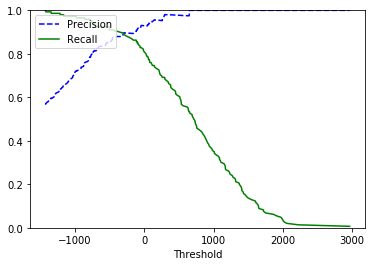

In [52]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### ROC 曲线

ROC 曲线是真正例率（true positive rate，另一个名字叫做召回率）对假正例率（false positive rate, FPR）的曲线。

> ROC曲线下面面积（AUC）越接近1，表示模型效果越好

In [53]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_1, y_scores)

In [54]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

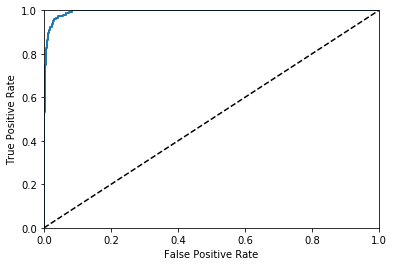

In [55]:
plot_roc_curve(fpr, tpr)

> 图中的点线是一个完全随机的分类器生成的 ROC 曲线；一个好的分类器的 ROC 曲线应该尽可能远离这条线（即向左上角方向靠拢）。

一个比较分类器之间优劣的方法是：测量ROC曲线下的面积（AUC）。一个完美的分类器的 ROC AUC 等于 1，而一个纯随机分类器的 ROC AUC 等于 0.5。Scikit-Learn 提供了一个函数来计算 ROC AUC：

In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_1, y_scores)

0.9945636187914951

# 多类分类

二分类器只能区分两个类，而多类分类器（也被叫做多项式分类器）可以区分多于两个类。

一些算法（比如随机森林分类器或者朴素贝叶斯分类器）可以直接处理多类分类问题。其他一些算法（比如 SVM 分类器或者线性分类器）则是严格的二分类器。然后，有许多策略可以让你用二分类器去执行多类分类。

__OvA__：

举例子，创建一个可以将图片分成 10 类（从 0 到 9）的系统的一个方法是：训练10个二分类器，每一个对应一个数字（探测器 0，探测器 1，探测器 2，以此类推）。然后当你想对某张图片进行分类的时候，让每一个分类器对这个图片进行分类，选出决策分数最高的那个分类器。这叫做“一对所有”（OvA）策略（也被叫做“一对其他”）。

__OvO__：

另一个策略是对每一对数字都训练一个二分类器：一个分类器用来处理数字 0 和数字 1，一个用来处理数字 0 和数字 2，一个用来处理数字 1 和 2，以此类推。这叫做“一对一”（OvO）策略。如果有 N 个类。你需要训练  N*(N-1)/2  个分类器。对于 MNIST 问题，需要训练 45 个二分类器！当你想对一张图片进行分类，你必须将这张图片跑在全部45个二分类器上。然后看哪个类胜出。OvO 策略的主要有点是：每个分类器只需要在训练集的部分数据上面进行训练。这部分数据是它所需要区分的那两个类对应的数据。

> 一些算法（比如 SVM 分类器）在训练集的大小上很难扩展，所以对于这些算法，OvO 是比较好的，因为它可以在小的数据集上面可以更多地训练，较之于巨大的数据集而言。但是，对于大部分的二分类器来说，OvA 是更好的选择。

> Scikit-Learn 可以探测出你想使用一个二分类器去完成多分类的任务，它会自动地执行 OvA（除了 SVM 分类器，它使用 OvO）。

In [57]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [60]:
sgd_clf.predict([X_train[1449]])

array([1])

上面的代码在训练集上训练了一个 `SGDClassifier`。这个分类器处理原始的目标class，从 0 到 9（y_train），而不是仅仅探测是否为 5 （y_train_1）。然后它做出一个判断（在这个案例下只有一个正确的数字）。

在幕后，__Scikit-Learn 实际上训练了 10 个二分类器，每个分类器都产生一张图片的决策数值，选择数值最高的那个类__。

> 为了证明这是真实的，可以调用 `decision_function()` 方法。不是返回每个样例的一个数值，而是返回 10 个数值，一个数值对应于一个类。

In [64]:
decision_scores = sgd_clf.decision_function([X_train[1449]])
decision_scores

array([[-4696.45105715,   455.49594268, -3614.79472717, -2858.28725634,
        -2323.14972698, -2247.7223323 , -3414.19692014, -1595.65053349,
         -800.59781784, -4651.5965577 ]])

In [65]:
sgd_clf.classes_[np.argmax(decision_scores)]

1

如果想强制 Scikit-Learn 使用 OvO 策略或者 OvA 策略，你可以使用 `OneVsOneClassifier` 类或者 `OneVsRestClassifier` 类。这两个类将会返回一个 estimator ，你可以和使用原 estimator 一样使用。

## 误差分析

首先，你可以检查混淆矩阵。你需要使用 `cross_val_predict()` 做出预测，然后调用 `confusion_matrix()` 函数。

In [67]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[143,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 142,   0,   0,   0,   0,   1,   0,   3,   0],
       [  1,   0, 141,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 141,   0,   2,   0,   0,   2,   2],
       [  0,   0,   0,   0, 143,   0,   1,   1,   0,   0],
       [  1,   2,   1,   0,   1, 140,   1,   0,   0,   2],
       [  0,   2,   0,   0,   1,   0, 143,   0,   0,   0],
       [  0,   0,   0,   1,   1,   0,   0, 139,   0,   3],
       [  0,   7,   1,   4,   0,   2,   0,   0, 126,   2],
       [  0,   1,   0,   1,   0,   1,   0,   2,   8, 132]])

这里是一对数字。使用 Matplotlib 的 `matshow()` 函数，将混淆矩阵以图像的方式呈现，将会更加方便。

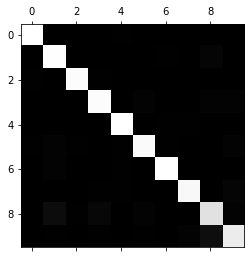

In [69]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

### 误差数据图像

让我们关注仅包含误差数据的图像呈现。首先你需要将混淆矩阵的每一个值除以相应类别的图片的总数目。这样子，你可以比较错误率，而不是绝对的错误数（这对大的类别不公平）。

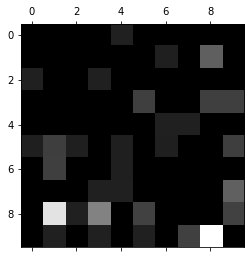

In [71]:
row_sums = conf_mx.sum(axis=1 , keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0) # 用 0 来填充对角线。这样子就只保留了被错误分类的数据。
plt.matshow(norm_conf_mx, cmap=plt.cm.gray) # 行代表实际类别，列代表预测的类别。亮（白）的部分代表分错的

# 多标签分类

到目前为止，所有的样例都总是被分配到仅一个类。有些情况下，你也许想让你的分类器给一个样例输出多个类别。比如说，思考一个人脸识别器。如果对于同一张图片，它识别出几个人，它应该做什么？当然它应该给每一个它识别出的人贴上一个标签。比方说，这个分类器被训练成识别三个人脸，Alice，Bob，Charlie；然后当它被输入一张含有 Alice 和 Bob 的图片，它应该输出  [1, 0, 1]  （意思是：Alice 是，Bob 不是，Charlie 是）。这种输出多个二值标签的分类系统被叫做多标签分类系统。

有许多方法去评估一个多标签分类器，和选择正确的量度标准，这取决于你的项目。举个例子，一个方法是对每个个体标签去量度 F1 值（或者前面讨论过的其他任意的二分类器的量度标准），然后计算平均值。

```python
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")
```

# 多输出分类

它是多标签分类的简单泛化，在这里每一个标签可以是多类别的（比如说，它可以有多于两个可能值）。